In [1]:
# conda activate aso_design
import sys
from pathlib import Path

p = Path.cwd()
while p != p.parent and not (p / "pyproject.toml").exists():
    p = p.parent

sys.path.insert(0, str(p))
print("Project root:", p)



import pandas as pd
from notebooks.consts import *
from tauso.file_utils import read_human_genome_fasta_dict
from tauso.consts import *
import numpy as np
from tauso.util import get_antisense
import pickle
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.file_utils import read_human_genome_fasta_dict
import RNA

Project root: /home/nivd1/TAUSO


In [2]:
csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
all_data = pd.read_csv(str(csv_path), low_memory=False)

Preprocessing ASO Experimental Dataset

In [3]:
from notebooks.notebook_utils import log_correction

# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data_no_nan) # to avoid log 0

In [4]:
# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
# Remove non-human or negative controls from the gene list
genes_u.remove('HBV')
genes_u.remove('negative_control')






In [5]:
from notebooks.notebook_utils import read_cached_gene_to_data

gene_to_data = read_cached_gene_to_data(genes_u)

In [6]:
# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

# Define names for new columns
SENSE_SEQUENCE = 'sense_sequence'
PRE_MRNA_SEQUENCE = 'pre_mrna_sequence'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'

# Initialize new columns
all_data_human_gene[SENSE_SEQUENCE] = ""
all_data_human_gene[PRE_MRNA_SEQUENCE] = ""
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)

# Iterate over each row and compute the antisense complement and the gene's pre-mRNA
for index, row in all_data_human_gene.iterrows():
    gene_name = row[CANONICAL_GENE]

    if gene_name not in gene_to_data:
        continue  # Skip genes not found in genome annotation

    locus_info = gene_to_data[gene_name]
    pre_mrna = locus_info.full_mrna
    antisense = row[SEQUENCE]
    sense = get_antisense(antisense)
    idx = pre_mrna.find(sense)

    # Store computed sequences in new columns
    all_data_human_gene.loc[index, SENSE_START] = idx
    all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)
    all_data_human_gene.at[index, SENSE_SEQUENCE] = sense
    all_data_human_gene.at[index, PRE_MRNA_SEQUENCE] = pre_mrna

In [7]:
all_data_human_gene.columns

Index(['index', 'ISIS', 'Target_gene', 'Cell_line', 'Density(cells/well)',
       'Transfection', 'ASO_volume(nM)', 'Treatment_Period(hours)',
       'Primer_probe_set', 'Sequence', 'Modification', 'Location',
       'Chemical_Pattern', 'Linkage', 'Linkage_Location', 'Smiles',
       'Inhibition(%)', 'seq_length', 'Canonical Gene Name',
       'Cell line organism', 'Transcript', 'Location_in_sequence',
       'Location_div_by_length', 'true_length_of_seq', 'mod_scan',
       'cell_line_uniform', 'log_inhibition', 'sense_sequence',
       'pre_mrna_sequence', 'sense_start', 'sense_length'],
      dtype='object')

In [8]:
all_data_human_gene.head()

,index,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,...,Location_in_sequence,Location_div_by_length,true_length_of_seq,mod_scan,cell_line_uniform,log_inhibition,sense_sequence,pre_mrna_sequence,sense_start,sense_length
0,0,540733,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCTAAAACAAATGCTA,...,41212.0,0.901972,16,0,A431,-4.204842,TAGCATTTGTTTTAGC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,41212,16
1,1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,...,23686.0,0.518395,16,0,A431,-4.532707,GATATTCACCATTATA,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,23686,16
2,2,540806,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCATGAAGATTTCTGG,...,43363.0,0.949049,16,1,A431,-3.637849,CCAGAAATCTTCATGC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,43363,16
3,3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,...,23680.0,0.518264,16,0,A431,-4.276805,TTTGAAGATATTCACC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,23680,16
4,4,651490,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,CACTTGTACTAGTATG,...,41168.0,0.901009,16,0,A431,-4.159039,CATACTAGTACAAGTG,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,41168,16


In [9]:
new_genes_u = genes_u.copy()
fix_genes = ["KRAS","SOD1","YAP1",'PKK'] 
for fg in fix_genes:
    new_genes_u.append(fg)


In [10]:
from src.tauso.genome.read_human_genome import get_locus_to_data_dict

gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=set(genes_u))
g = next(iter(gene_to_data.keys()))
li = gene_to_data[g]

print("Example gene:", g)
print("Type:", type(li))
print("Dir:", [a for a in dir(li) if not a.startswith("_")][:50])

if isinstance(li, dict):
    print("Keys:", li.keys())


Elapsed DB:  0.00036072731018066406
Elapsed Fasta:  0.00036072731018066406
Length:  3099750718
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  start_codon
Feature type:  start_codon
Feature type:  transcript
Feature type:  CDS
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CD

Get CDS and premRNA windows

In [11]:
from src.tauso.util import get_antisense
from src.tauso.algorithms.genomic_context_windows import add_external_mrna_and_context_columns
df_with_context = add_external_mrna_and_context_columns(df =all_data_no_nan_human, sequence_col=SEQUENCE, canonical_gene_col=CANONICAL_GENE, get_antisense_fn=get_antisense, gene_subset=new_genes_u) 

FLANK_SIZES_CDS = [20, 30, 40, 50, 60, 70]
CDS_WINDOWS = [20, 30, 40, 50, 60, 70]

Elapsed DB:  0.00032401084899902344
Elapsed Fasta:  0.00032401084899902344
Length:  3099750718
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  start_codon
Feature type:  start_codon
Feature type:  transcript
Feature type:  CDS
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CD

Generate ENC Features

In [12]:
from src.tauso.features.seq_features import compute_ENC

# Define flank sizes
CDS_WINDOWS = FLANK_SIZES_CDS

# 1. Local ENC for each flank
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    enc_col = f"ENC_score_{flank}_CDS"

    df_with_context[enc_col] = df_with_context[local_col].apply(compute_ENC)

# 2. Global ENC for full CDS (calculate once)
df_with_context["ENC_score_global_CDS"] = df_with_context["cds_sequence"].apply(compute_ENC)



In [13]:
ENC_LIST = [col for col in df_with_context.columns if 'ENC_score' in col]

In [14]:
from notebooks.features.RNaseH.correlation_test import analyze_feature_correlations
results_df = analyze_feature_correlations(df_with_context, target='log_inhibition')
display(results_df)



/home/nivd1/TAUSO/notebooks/features/RNaseH/correlation_test.py:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/home/nivd1/TAUSO/notebooks/features/RNaseH/correlation_test.py:73: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(x, y)


,Feature,Pearson,Spearman,NMI_max
16,Inhibition(%),0.891,1.000,2.047
1,ISIS,-0.051,-0.129,0.152
0,index,0.340,0.325,0.114
21,Location_in_sequence,-0.022,0.204,0.107
26,sense_start,-0.027,0.199,0.107
6,ASO_volume(nM),0.305,0.325,0.095
57,ENC_score_global_CDS,-0.300,-0.289,0.064
22,Location_div_by_length,0.056,0.103,0.045
54,ENC_score_50_CDS,0.100,0.062,0.045
55,ENC_score_60_CDS,0.087,0.050,0.040


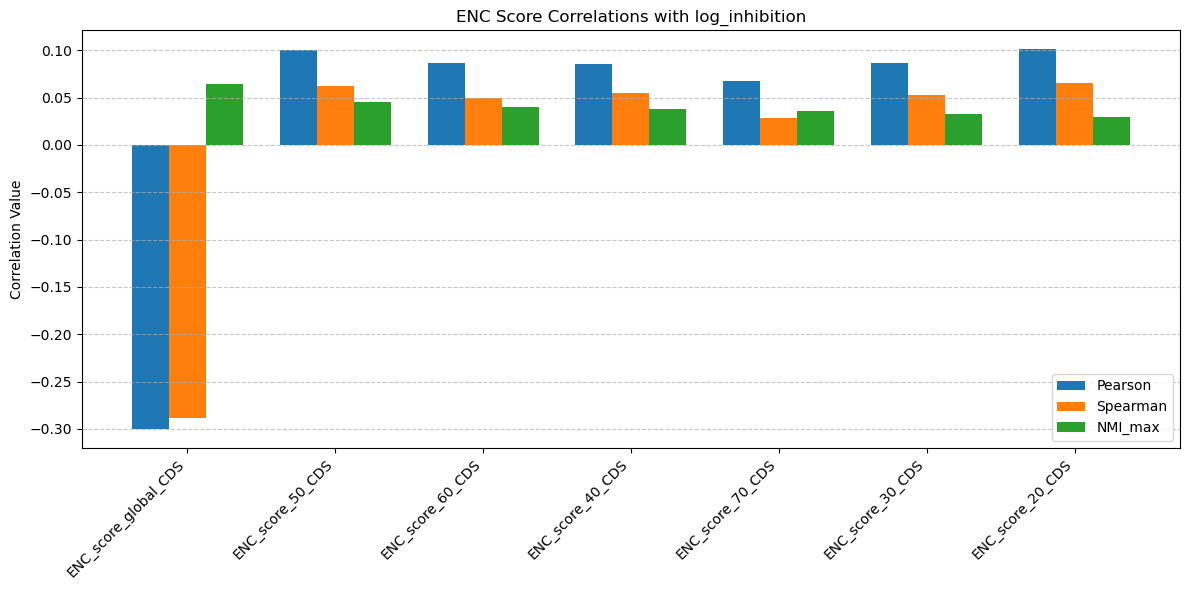

In [15]:
from notebooks.features.RNaseH.correlation_test import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='ENC', title='ENC Score Correlations with log_inhibition')

In [16]:
from notebooks.features.feature_extraction import save_feature
for feat in ENC_LIST:
    save_feature(df_with_context, feat)